In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
import hdbscan
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.metrics import sensitivity_score, specificity_score

from sklearn.metrics import roc_curve, auc
from gower import gower_matrix
from scipy import stats

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', None)

In [52]:
def get_dataset(fname):
    with open('names', 'r') as fcolnames:
        colnames = [name.split(':')[0] for name in fcolnames.readlines()]
    
        df = pd.read_csv(fname, names=colnames, index_col=False)
        return df

In [53]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, replace_dict):
        self.replace_dict = replace_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        return X.replace(self.replace_dict)

    def get_feature_names_out(self, names):
        return names

    def set_output(self, *, transform):
        assert transform == 'pandas'


In [54]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        if X.columns is not None:
            X = X.drop(self.columns, axis=1)
            self.feature_names = [name for name in X.columns if name not in self.columns]
            
        return X

    def get_feature_names_out(self, names):
        if names is None:
            return names
            
        return [name for name in names if name not in self.columns]


    def set_output(self, *, transform):
        assert transform == 'pandas'


In [55]:
class ZScoreOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, cols, factor=3):
        self.factor = factor
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print('LEN' + str(len(X[(np.abs(stats.zscore(X[self.cols], nan_policy='omit', axis=0)) > self.factor).any(axis=1)])))
        return X[~(np.abs(stats.zscore(X[self.cols], nan_policy='omit', axis=0)) > self.factor).any(axis=1)]

    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'

    

In [56]:
class RangeOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, col, min, max):
        self.col = col
        self.min = min
        self.max = max
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[(X[self.col] >= self.min) & (X[self.col] <= self.max) | X[self.col].isna()]

    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'

    

In [57]:
class ColumnBackPusher(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        col = X[self.col]
        X = X.drop(self.col, axis=1)
        return pd.concat([X, col], axis=1)
        
    def get_feature_names_out(self, names):
        return [name for name in names if name != self.col] + [self.col]
        
    def set_output(self, *, transform):
        assert transform == 'pandas'


In [58]:


class IndicatorLabelProducer():
    def __init__(self, indicator_map):
        self.indicator_map = indicator_map

    def __call__(self, given_label: str) -> str:
        if '|' in given_label:
            given_label = given_label.split('|')[1]

        
        diagset = set(given_label)
        
        for label, options in self.indicator_map.items():
            if not diagset.isdisjoint(set(options)):
                return label

        return np.NaN

class MappingLabelProducer():
    def __init__(self, mappings):
        self.mappings = mappings

    def __call__(self, given_label: str) -> str:
        if given_label in self.mappings:
            return self.mappings[given_label]

        return np.NaN
        

In [59]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scale=1, **kwargs):
        self.scale = scale
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        self.scaler.fit(X)
        return self

    def transform(self, X, y=None):
        X_scaled = self.scaler.transform(X)
        return self.scale * X_scaled
    
    def get_feature_names_out(self, names):
        return names
        
    def set_output(self, *, transform):
        assert transform == 'pandas'


In [60]:
def reencode_dataset(df, label_producer):
    df['diagnosis'] = df['diagnosis'].apply(lambda ref: ref.split('[')[0])
    df['diagnosis'] = df['diagnosis'].apply(lambda ref: ref.split('.')[0])
    df['diagnosis'] = df['diagnosis'].apply(label_producer)

    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='raise')
        except:
            pass

    return df.applymap(lambda val: np.nan if val == '?' else val)

In [61]:
indi_map = {
    'hyper' : 'ABCD',
    'hypo' : 'EFGH',
    'neg' : '-',
}

classes_map = {
    'hyperthyroid' : 'hyper',
}

classes = ['hypo', 'neg', 'hyper']

df1 = get_dataset('thyroid0387.data')
df1 = reencode_dataset(df1, IndicatorLabelProducer(indi_map))

df2 = get_dataset('allhyper.data')
df2 = reencode_dataset(df2, MappingLabelProducer(classes_map))
df = pd.concat([df1], ignore_index=True, axis=0)
df = df.dropna(subset=['diagnosis'])

In [62]:
df = df.drop_duplicates(keep='first')
df.diagnosis.value_counts()


neg      6763
hypo      659
hyper     228
Name: diagnosis, dtype: int64

In [63]:

bool_cols = ['on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'psych']

numeric_cols = ['age','TSH',
       'T3', 'TT4', 'T4U', 'FTI']

cols_to_drop = ['TSH measured',
       'T3 measured', 'TT4 measured', 'T4U measured', 
       'FTI measured', 'TBG measured', 'referral source', 'TBG', 'hypopituitary']


def convert_to_numeric(df):
    return df.apply(pd.to_numeric, errors='ignore')


numeric_transformer = FunctionTransformer(convert_to_numeric)
label_enc = OrdinalEncoder(categories=[classes], dtype=np.int64)

prep = Pipeline(steps=[
    ('column dropper', ColumnDropper(cols_to_drop)),
    ('feature encoder', ColumnTransformer(transformers=[
        ('gender map', ValueReplacer({'M':0, 'F':1}), ['sex']),
        ('bool map', ValueReplacer({'f': 0, 't': 1}), bool_cols),
        ('label encoder',  label_enc, ['diagnosis'])
    ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform="pandas")),
    ('numeric cast', numeric_transformer),
    ('zoutliers', ZScoreOutlierRemover(numeric_cols, 8)),
    ('age outliers', RangeOutlierRemover('age', 0, 100)),
    ('TSH outliers', RangeOutlierRemover('TSH', 0, 15)),
    ('label', ColumnBackPusher('diagnosis'))
]).set_output(transform='pandas')

In [64]:
df = prep.fit_transform(df)

LEN38


In [65]:
df.dtypes

sex                          float64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
psych                          int64
age                            int64
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
diagnosis                      int64
dtype: object

In [66]:
print(df.isna().sum(axis=0))

null_counts = df.isnull().sum(axis=1)

sex                           230
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
psych                           0
age                             0
TSH                           716
T3                           2125
TT4                           340
T4U                           650
FTI                           643
diagnosis                       0
dtype: int64


In [67]:
print(df['diagnosis'].value_counts())
print(df.dtypes)

1    6748
0     350
2     212
Name: diagnosis, dtype: int64
sex                          float64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
psych                          int64
age                            int64
TSH                          float64
T3                           float64
TT4                          float64
T4U                          float64
FTI                          float64
diagnosis                      int64
dtype: object


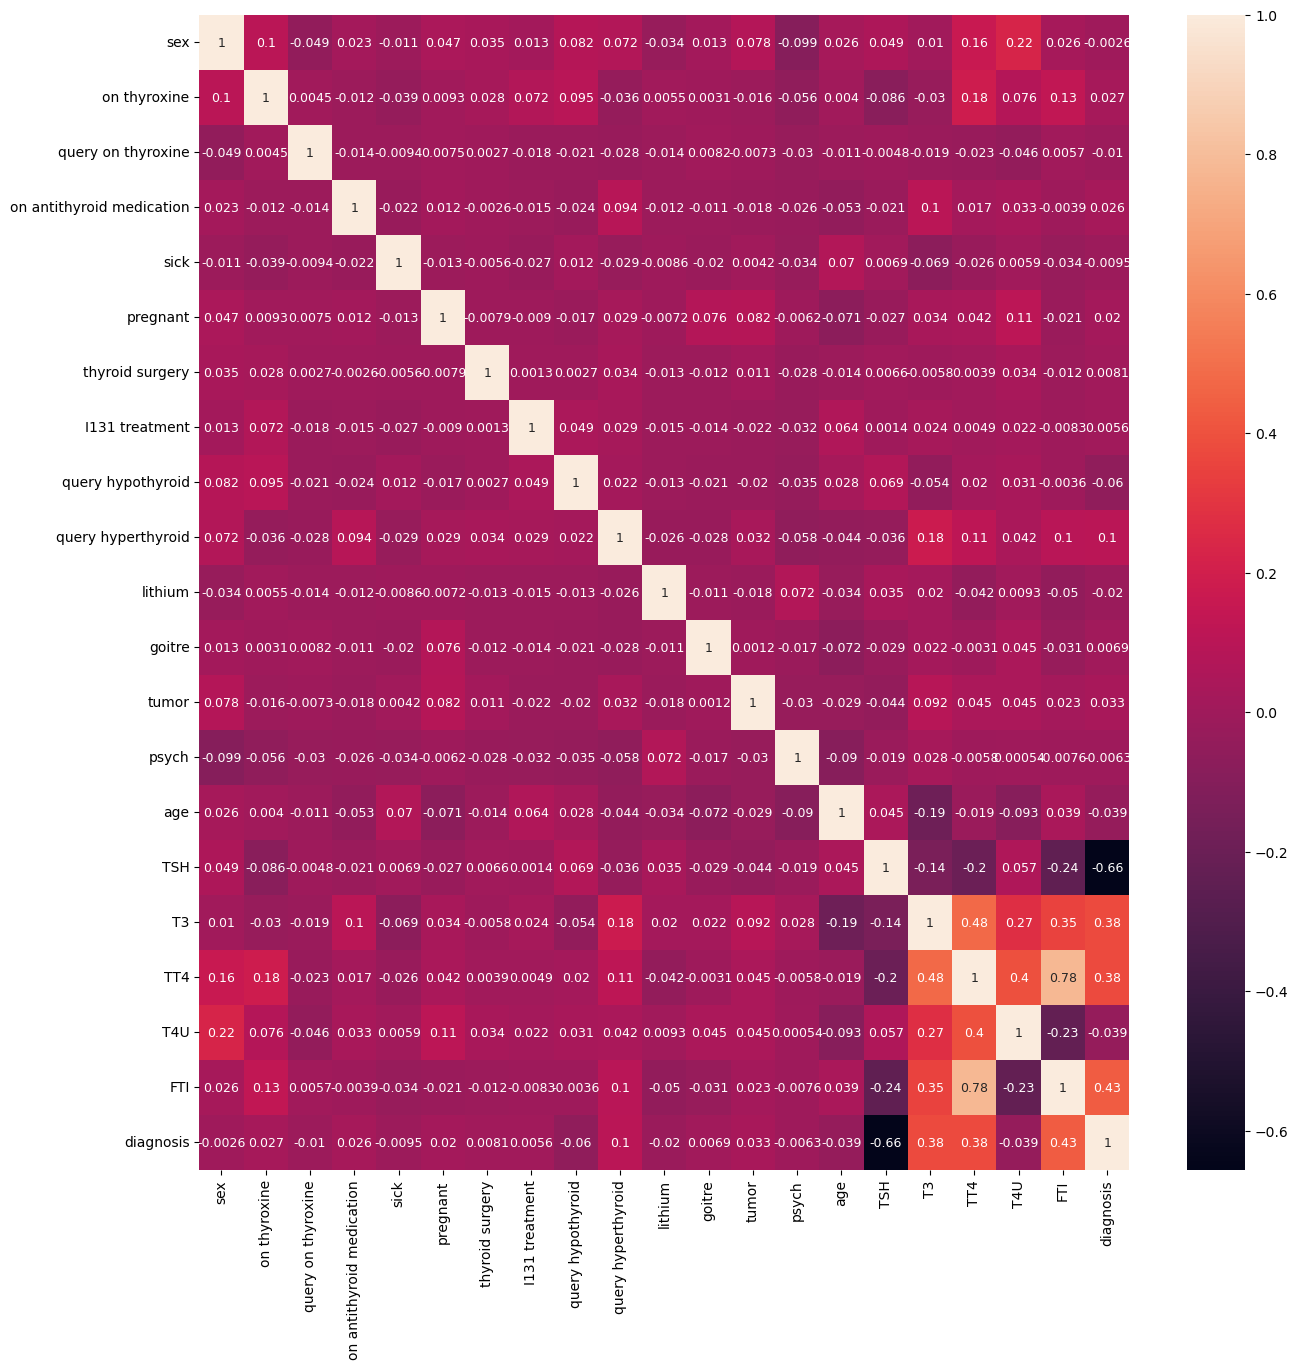

In [68]:

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, annot_kws={
    "fontsize": 9})

plt.show() 

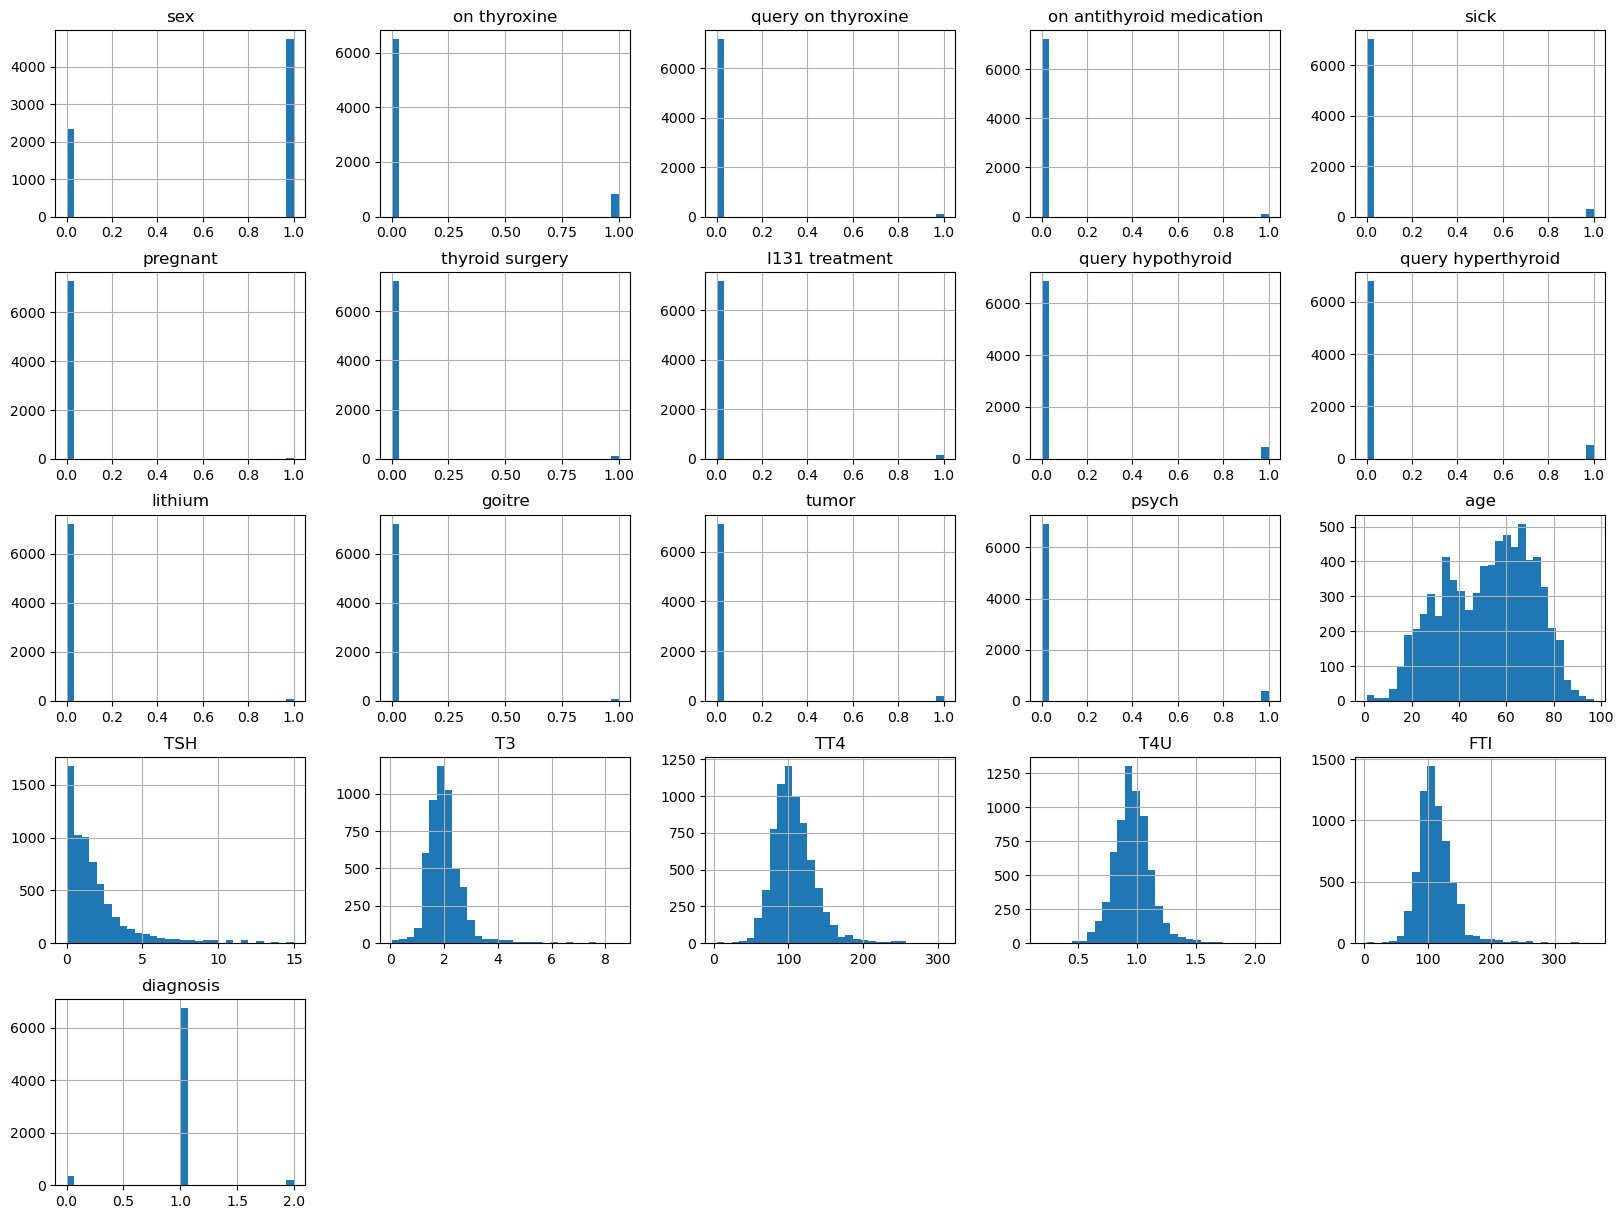

In [69]:
df.hist(bins=30, figsize=(20, 15))

plt.show() 

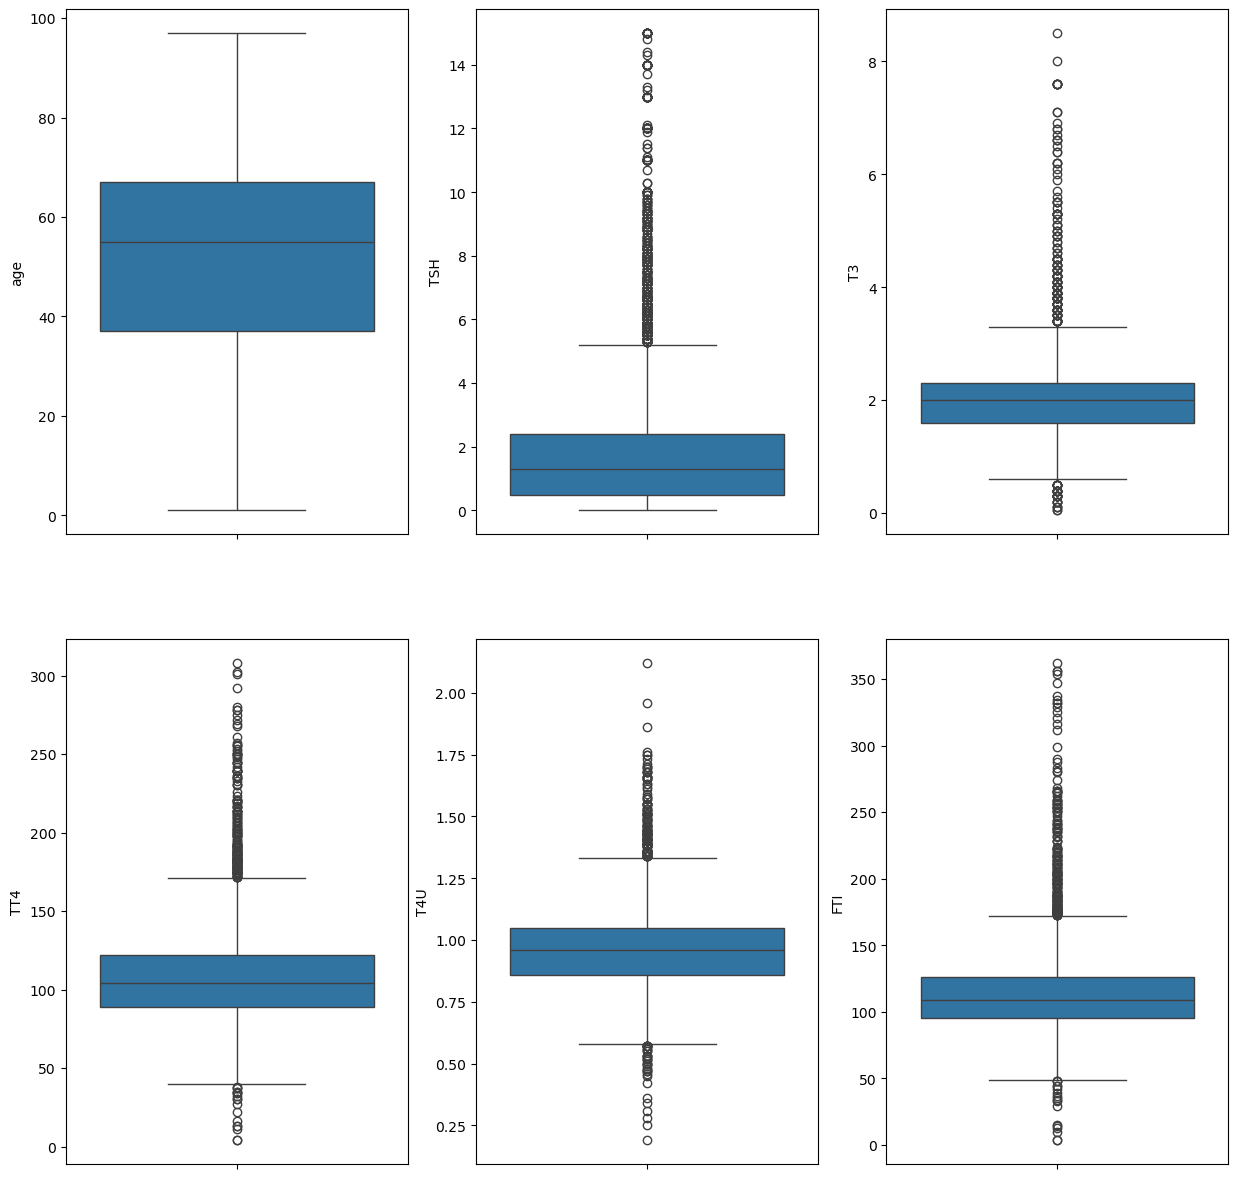

In [70]:

cols = int(np.ceil(np.sqrt(len(numeric_cols))))
f, axes = plt.subplots(nrows=len(numeric_cols) // cols, ncols=cols, figsize=(15, 15))
 
count = 0
for col in numeric_cols:
    sns.boxplot(df[col], ax=axes[count // cols, count % cols])
    count+=1
    
plt.show()

In [71]:
mean_vector = np.empty((0, len(df.columns) - 1))

for label in df.iloc[:, -1].unique():
    vector = np.array([])
    
    for col in df.columns[:-1]:
        if col in numeric_cols:
            vector = np.append(vector, df[col].median())
        else:
            vector = np.append(vector, df[col].mode())

    mean_vector = np.vstack([mean_vector,vector])


In [72]:
X = pd.DataFrame(df.iloc[:, :-1])
y = df.iloc[:, -1]
print(y.value_counts())

1    6748
0     350
2     212
Name: diagnosis, dtype: int64


In [73]:
preproc = Pipeline(steps=[
    ('scaler', ColumnTransformer(transformers=[
        ('scaler', CustomScaler(1), numeric_cols),
    ], remainder='passthrough', verbose_feature_names_out=True).set_output(transform="pandas")),
    ('imputer', IterativeImputer(initial_strategy='median', add_indicator=False, max_iter=100))
]).set_output(transform='pandas')

In [74]:
X = preproc.fit_transform(X)

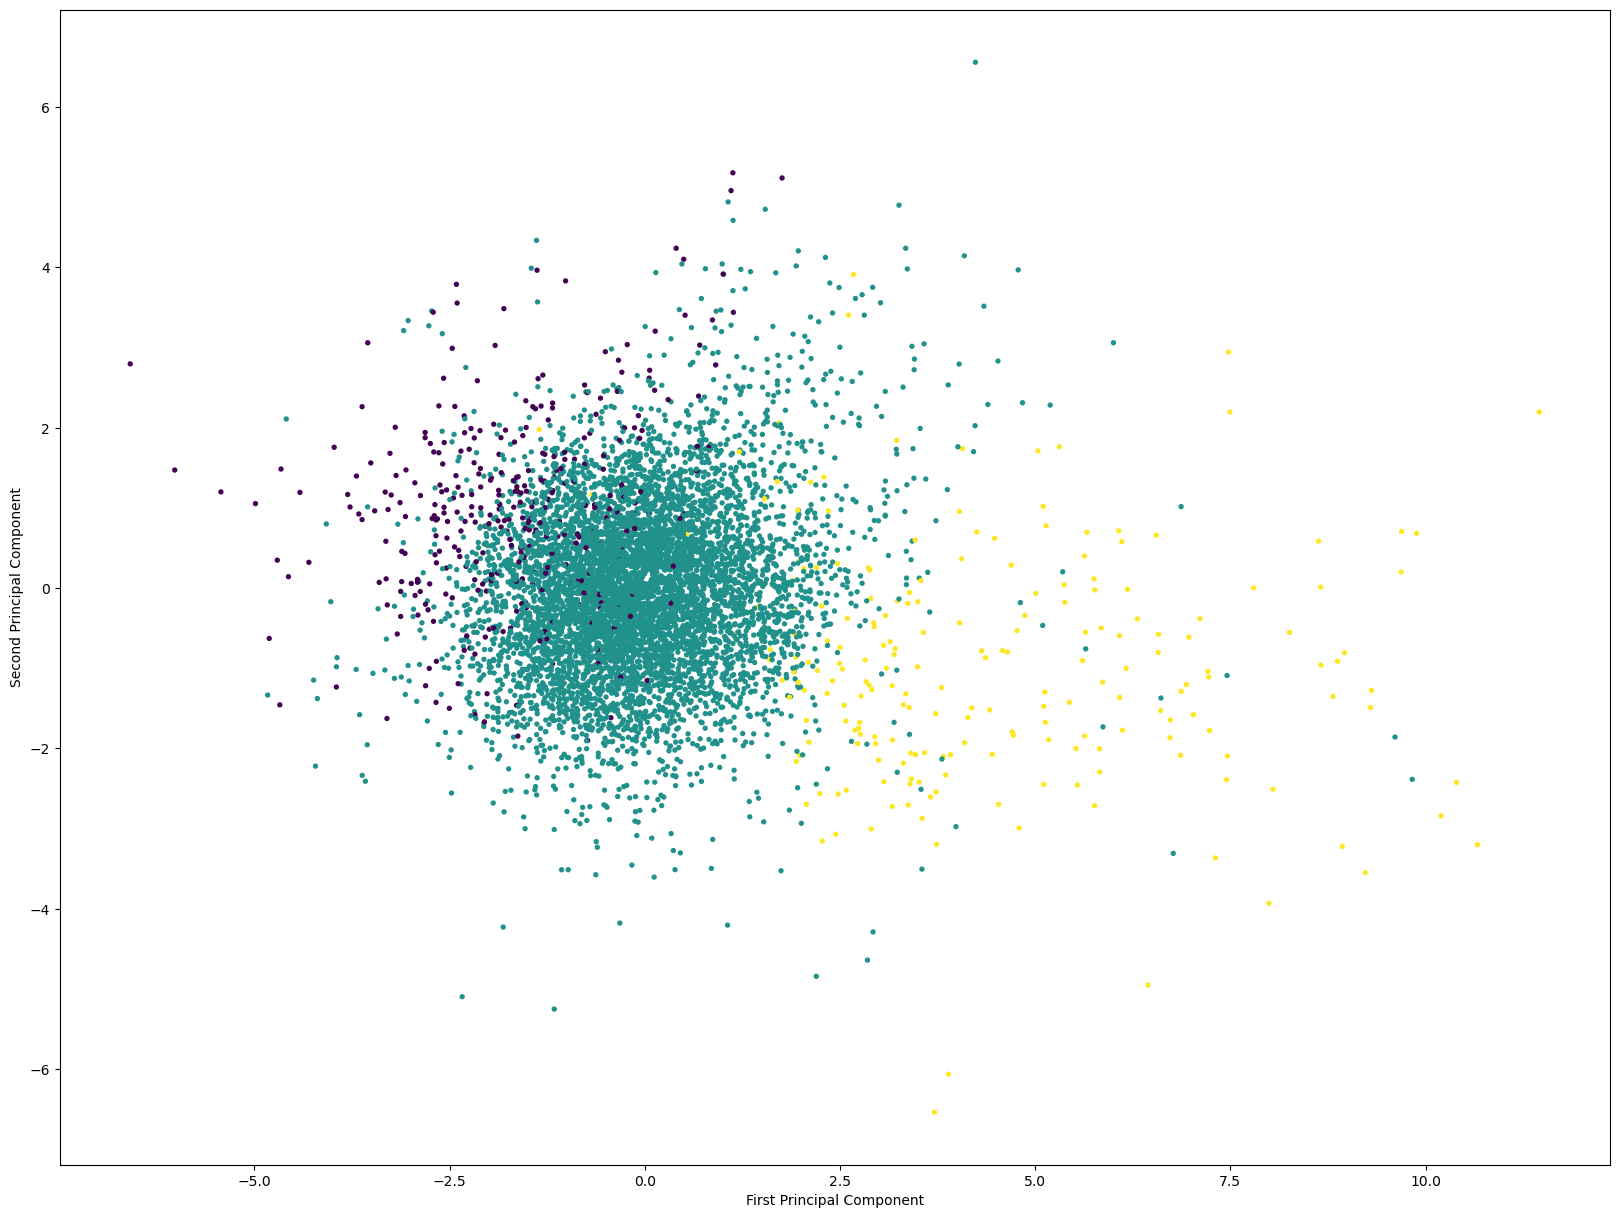

In [75]:
# PCA
pca = PCA(n_components=3)
X_pca_2d = pca.fit_transform(X)

def show_pca(labels):
    plt.figure(figsize=(20,15))
    plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=labels, s=8, cmap='viridis') # y is your target variable
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

show_pca(y)

In [76]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

def show_pca_3d(labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, s=7, cmap='viridis')

    # Add labels and title
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('PCA 3D Visualization')
    ax.mouse_init()


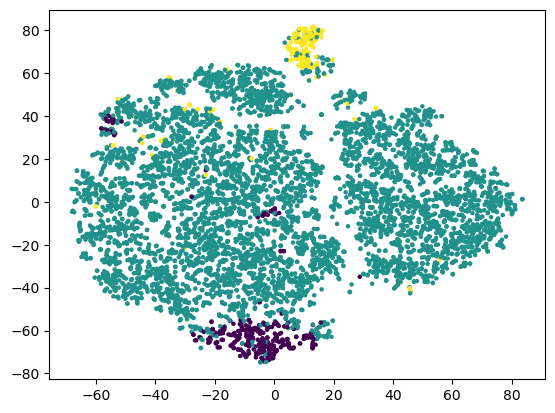

In [77]:
# TSNE
projection = TSNE(init='random', metric='manhattan', random_state=42).fit_transform(X)

def show_tsne(labels):
    plt.scatter(*projection.T, c=labels, s=5, cmap='viridis')
    plt.show()
    
show_tsne(y)

In [78]:
tsne = TSNE(n_components=3, random_state=0)
X_sne = tsne.fit_transform(X)

/tmp/ipykernel_12531/2402487808.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


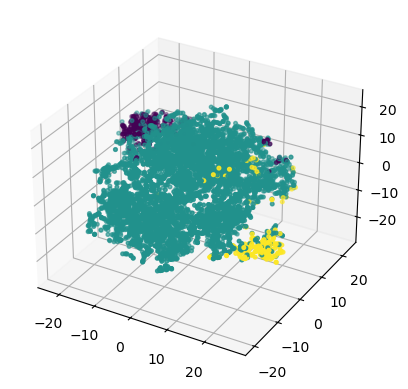

In [79]:
def show_tsne_3d(labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_sne[:, 0], X_sne[:, 1], X_sne[:, 2], c=labels, s=7, cmap='viridis')
    fig.show()

show_tsne_3d(y)

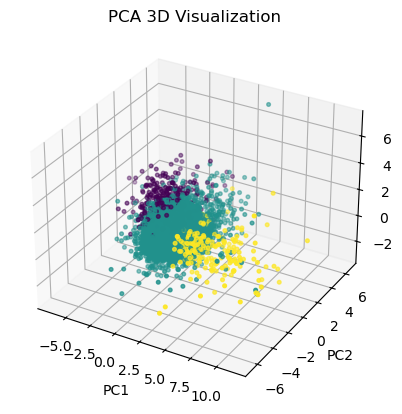

In [84]:
show_pca_3d(y)

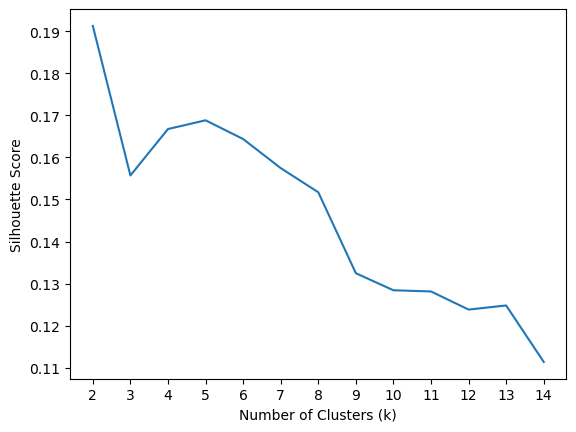

In [85]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
# Create a range of k values to try
k_values = range(2, 15)  

# Loop through k values and calculate silhouette score for each
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
import matplotlib.pyplot as plt
plt.plot(k_values, silhouette_scores)
plt.xticks(k_values)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

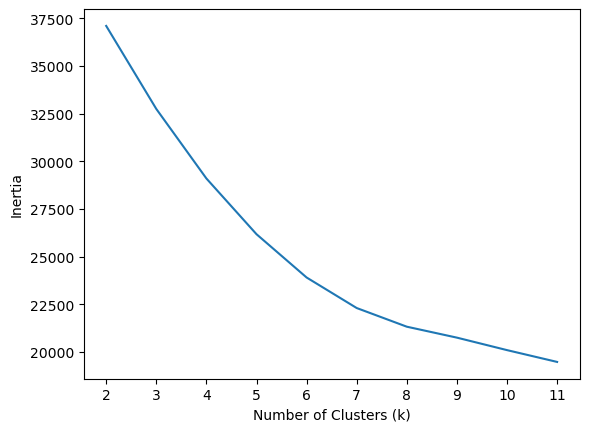

In [86]:
from sklearn.cluster import KMeans

# Create a range of k values to try
k_values = range(2, 12)

# Calculate inertia (sum of squared distances to closest cluster center) for each k
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.xticks(k_values)

# Plot the inertia values
plt.plot(k_values, inertia)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [87]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=5, max_iter=1200)

kmeans.fit(X)

KMeans(max_iter=1200, n_clusters=5)

In [88]:

cluster_labels = kmeans.labels_

# Create a DataFrame with true labels and cluster labels
labels_df = pd.DataFrame({'true_label': y, 'cluster': cluster_labels})

# Group by cluster and find the mode (dominant label) for each cluster
dominant_labels = labels_df.groupby(['cluster'])['true_label'].apply(lambda x: x.mode().iloc[0])

assigned_labels = np.array([dominant_labels.get(cluster, -1) for cluster in cluster_labels])
np.unique(assigned_labels, return_counts=True)


(array([0, 1, 2]), array([ 483, 6663,  164]))

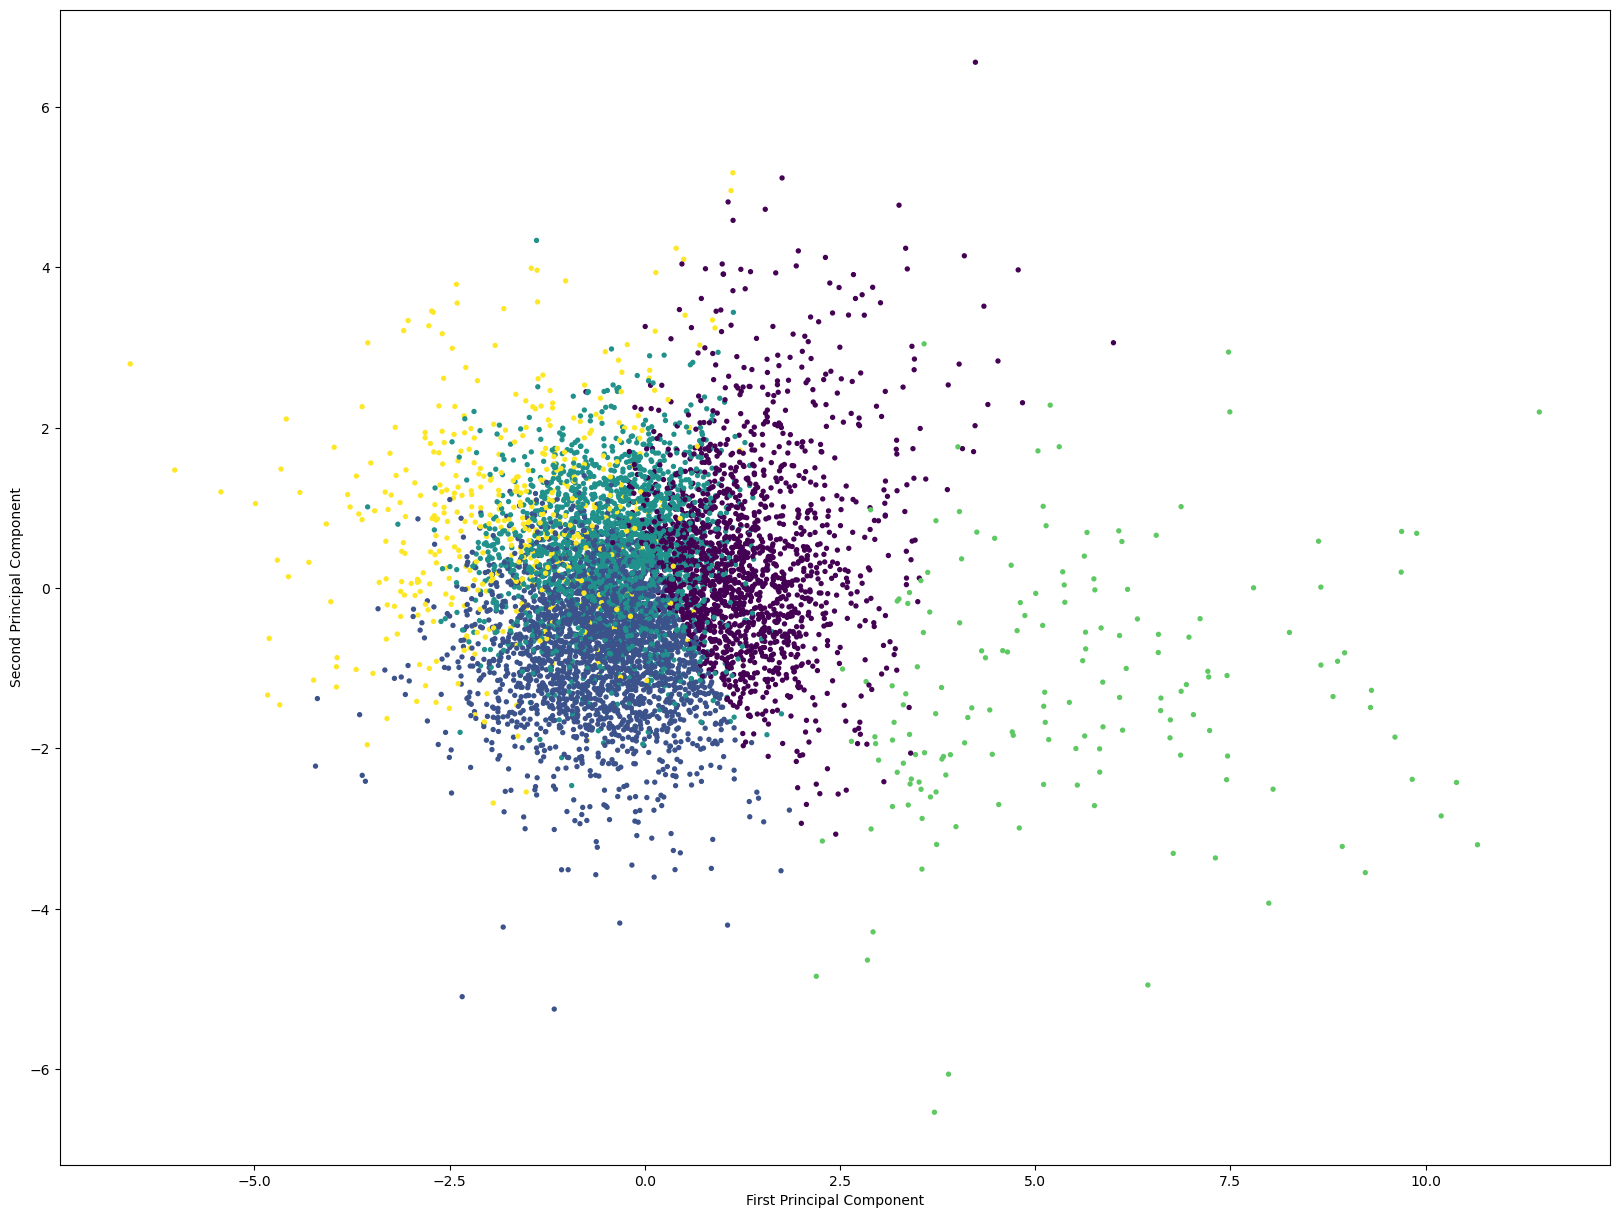

In [89]:
show_pca(kmeans.labels_)

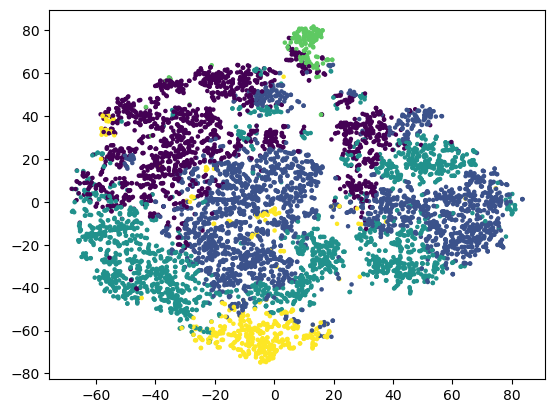

In [90]:

show_tsne(kmeans.labels_)


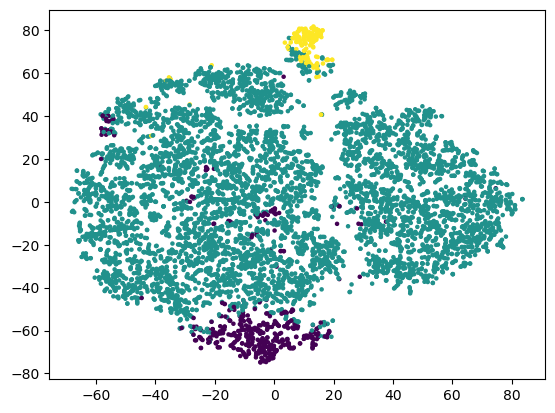

In [91]:
show_tsne(assigned_labels)


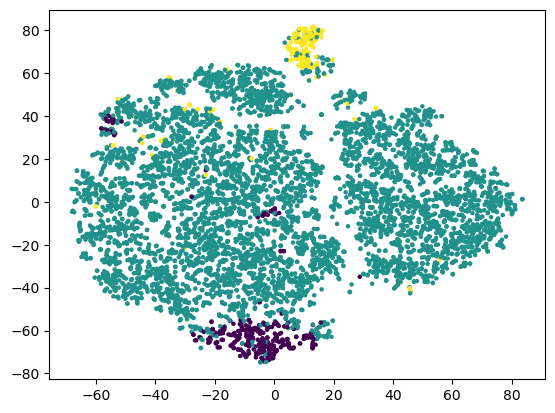

In [92]:
show_tsne(y)

/tmp/ipykernel_12531/2402487808.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


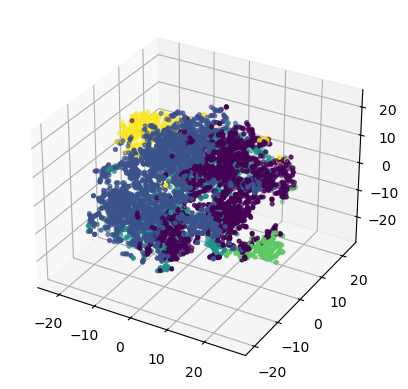

In [93]:

show_tsne_3d(kmeans.labels_)

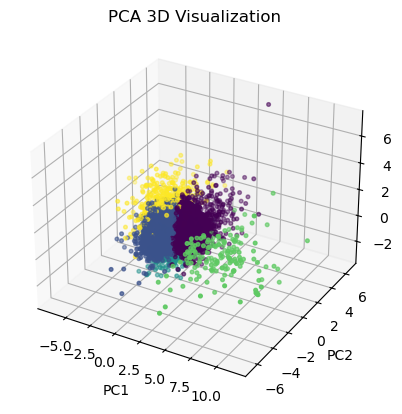

In [94]:
show_pca_3d(kmeans.labels_)

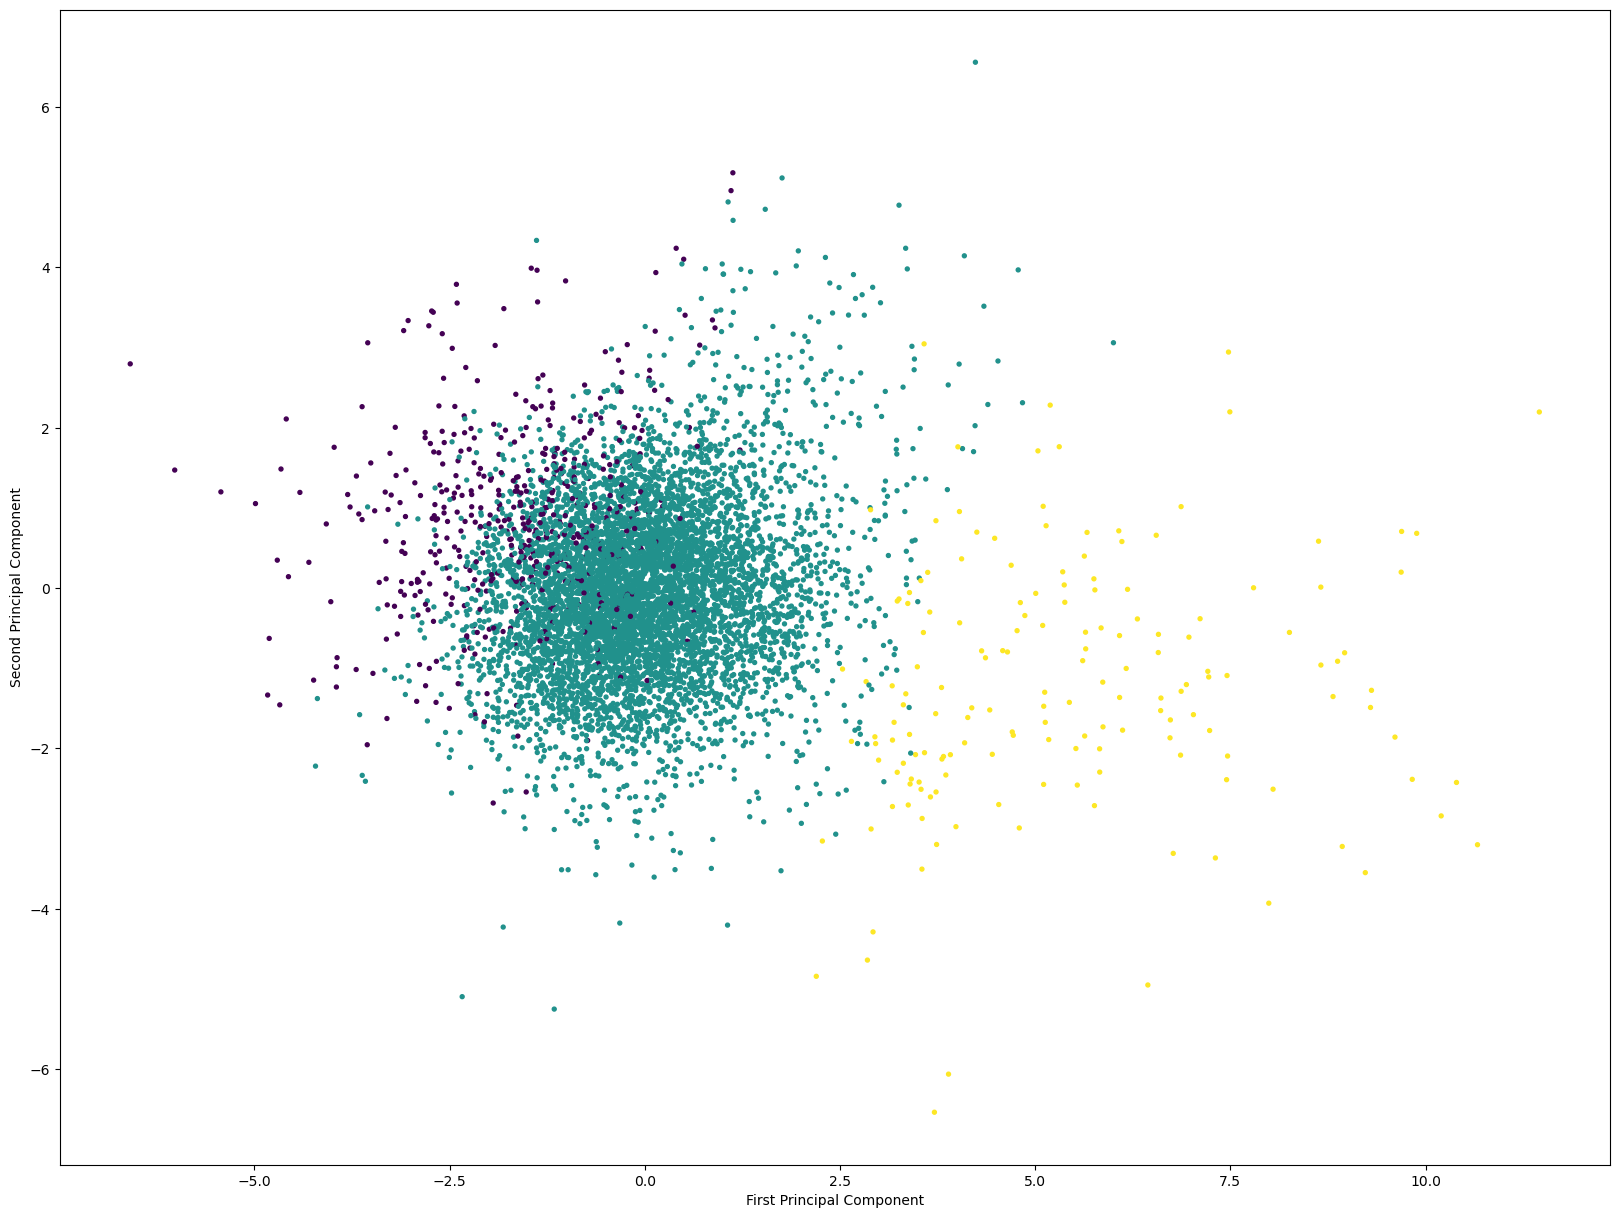

In [95]:
show_pca(assigned_labels)

/tmp/ipykernel_12531/2402487808.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


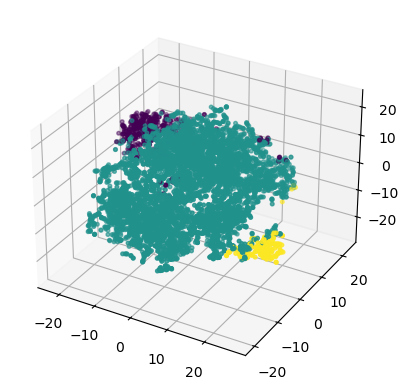

In [96]:
show_tsne_3d(assigned_labels)

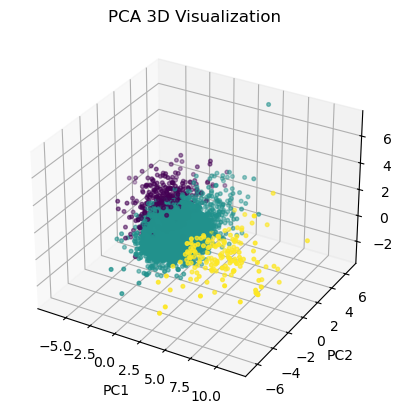

In [97]:
show_pca_3d(assigned_labels)

Accuracy: 0.9637482900136799
Precision (macro): 0.8344529007694118
Precision (micro): 0.9637482900136799
Precision (weighted): 0.9678521090225303
Recall (macro): 0.857285382484631
Recall (micro): 0.9637482900136799
Recall (weighted): 0.9637482900136799
F1-score (macro): 0.8348435562333457
F1-score (micro): 0.9637482900136799
F1-score (weighted): 0.9644049522207929


7310

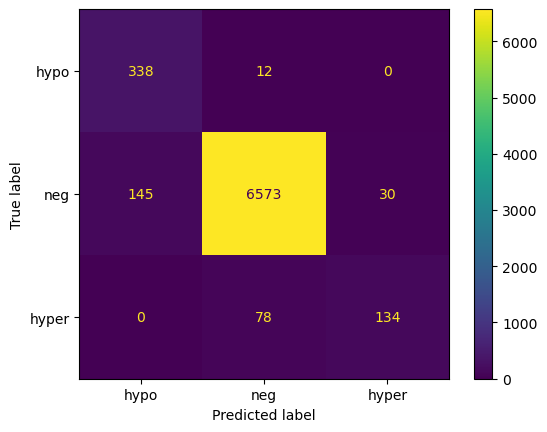

In [98]:
conf_mat = confusion_matrix(y, assigned_labels)
        
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                       display_labels=classes)
disp.plot()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Accuracy
print('Accuracy:', accuracy_score(y, assigned_labels))

print('Precision (macro):', precision_score(y, assigned_labels, average='macro'))
print('Precision (micro):', precision_score(y, assigned_labels, average='micro'))
print('Precision (weighted):', precision_score(y, assigned_labels, average='weighted'))

# Recall
print('Recall (macro):', recall_score(y, assigned_labels, average='macro'))
print('Recall (micro):', recall_score(y, assigned_labels, average='micro'))
print('Recall (weighted):', recall_score(y, assigned_labels, average='weighted'))

# F1-score
print('F1-score (macro):', f1_score(y, assigned_labels, average='macro'))
print('F1-score (micro):', f1_score(y, assigned_labels, average='micro'))
print('F1-score (weighted):', f1_score(y, assigned_labels, average='weighted'))
len(X)